In [2]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import lifesim
from lifesim.util.radiation import black_body

ModuleNotFoundError: No module named 'lifesim'

In [13]:
# planet parameters
temp_p = 265.  # in K
radius_p = 1.  # in earth rad
angsep = 0.1  # in arcsec

# star parameters
temp_s = 5778.  # in K
radius_s = 1.  # in sun rad

# system parameters
distance_s = 10.  # in pc
lat_s = 0.79  # in rad
z = 3  # in zodis

integration_time = 60*60*10

bus = lifesim.Bus()

bus.data.options.set_scenario('baseline')
bus.data.options.set_manual(spec_res=50)

instrument_base = lifesim.Instrument(name='inst_base')
bus.add_module(instrument_base)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst_base', 'transm'))
bus.connect(('inst_base', 'exo'))
bus.connect(('inst_base', 'local'))
bus.connect(('inst_base', 'star'))

bus.connect(('star', 'transm'))

instrument_base.apply_options()

fgamma = (black_body(mode='planet',
                     bins=bus.data.inst['wl_bins'],
                     width=bus.data.inst['wl_bin_widths'],
                     temp=temp_p,
                     radius=radius_p,
                     distance=distance_s
                     )
          / bus.data.inst['wl_bin_widths']
          * u.photon / u.second / (u.meter ** 3))

flux_planet_spectrum = [bus.data.inst['wl_bins'] * u.meter, fgamma]

spectrum, flux_planet, noise = instrument_base.get_spectrum(temp_s=temp_s,
                                                            radius_s=radius_s,
                                                            distance_s=distance_s,
                                                            lat_s=lat_s,
                                                            z=z,
                                                            angsep=angsep,
                                                            flux_planet_spectrum=flux_planet_spectrum,
                                                            integration_time=integration_time,
                                                            safe_mode=True)


In [14]:
noise_star = noise[1][1] * integration_time * bus.data.inst['eff_tot'] * 2
noise_ezodi = noise[2][0] * integration_time * bus.data.inst['eff_tot'] * 2
noise_lzodi = noise[1][0] * integration_time * bus.data.inst['eff_tot'] * 2

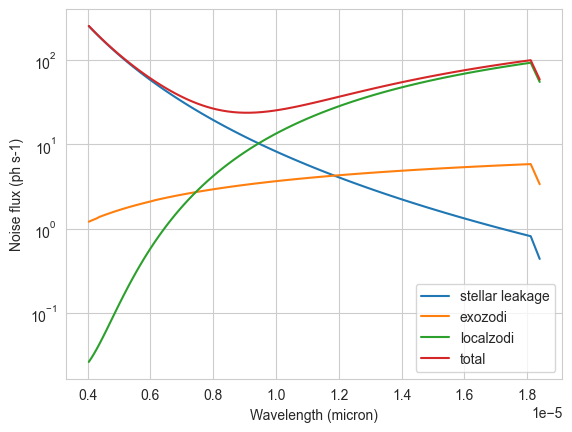

In [15]:
fig, ax = plt.subplots(dpi=100)

plt.plot(spectrum[0], noise_star / integration_time, label='stellar leakage')
plt.plot(spectrum[0], noise_ezodi / integration_time, label='exozodi')
plt.plot(spectrum[0], noise_lzodi / integration_time, label='localzodi')
plt.plot(spectrum[0], noise[0] / integration_time, label='total')

plt.xlabel('Wavelength (micron)')
plt.ylabel('Noise flux (ph s-1)')
plt.yscale('log')
plt.legend()
plt.show()